# Detección de anomalías en un marco de auditoría continua

## Referencias

PaySim:

- https://github.com/EdgarLopezPhD/PaySim
- https://www.kaggle.com/ealaxi/paysim1

GitHub:

- https://github.com/albertofalco/continous_audit_anomalies

Análisis exploratorio:

- https://github.com/pandas-profiling/pandas-profiling

Optimización de hyperparámetros:

- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
- https://proceedings.neurips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf
- http://proceedings.mlr.press/v28/bergstra13.pdf
- https://static.sigopt.com/b/20a144d208ef255d3b981ce419667ec25d8412e2/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf
- https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf
- https://machinelearningmastery.com/what-is-bayesian-optimization
- https://towardsdatascience.com/optimise-your-hyperparameter-tuning-with-hyperopt-861573239eb5
- https://github.com/hyperopt/hyperopt/wiki/FMin
- https://github.com/hyperopt
- https://www.youtube.com/watch?v=tdwgR1AqQ8Y
- https://www.youtube.com/watch?v=5nYqK-HaoKY
- https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d


## Atributos del dataset

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrig - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1. Configuración inicial

In [1]:
# Importación de librerias generales
import pandas as pd
import numpy as np
import os
import time

In [2]:
# Instalación de librerías necesarias.
os.chdir('..')
! pip install -q -r requirements.txt

In [3]:
# Impresión del directorio de trabajo.
print(os.getcwd())

D:\Alberto\OneDrive - Económicas - UBA\11 Trabajo Final de Especializacion\continous_audit_anomalies


In [4]:
# Configuración de punto flotante para pandas.
pd.options.display.float_format = '{:.2f}'.format

## 2. Lectura del dataset

In [5]:
# Lectura del dataset en formato csv.
file = 'fraud_detection_dataset.csv'
df = pd.read_csv(file)

In [6]:
# Impresión de los primeros registros.
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [7]:
# Tamaño del dataset.
print('Rows: %i' % df.shape[0])
print('Columns: %i' % df.shape[1])

Rows: 6362620
Columns: 11


In [8]:
# Corrección del nombre de columnas.
df.columns = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 
              'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 
              'isFlaggedFraud']

## 3. Análisis exploratorio inicial

### 3.1. Estadísticas descriptivas

In [9]:
# Obtención de estadisticas descriptivas.
df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


### 3.2. Verificaciones de integridad y consistencia

In [10]:
# Valores únicos.
print('Valores unicos: ')
print('step:', * df['step'].unique(), sep = ' ', end = '\n')
print('type:', * df['type'].unique(), sep = ' ', end = '\n')
print('isFraud:', * df['isFraud'].unique(), sep = ' ', end = '\n')
print('isFlaggedFraud:', * df['isFlaggedFraud'].unique(), sep = ' ', end = '\n')

Valores unicos: 
step: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 2

In [11]:
# Tabla de frecuencia absoluta para atributos relevantes.
print('Type: \n\n', df['type'].value_counts(), sep = '', end = '\n\n')
print('isFraud: \n\n', df['isFraud'].value_counts(), sep = '', end = '\n\n')
print('isFlaggedFraud: \n\n', df['isFlaggedFraud'].value_counts(), sep = '', end = '\n')

Type: 

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

isFraud: 

0    6354407
1       8213
Name: isFraud, dtype: int64

isFlaggedFraud: 

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64


In [12]:
# Proporción de originantes y destinatarios únicos sobre totales.
print('Proporción de valores únicos para el atributo "originante" ("nameOrig"): %.4f' % (len(df['nameOrig'].unique()) / len(df['nameOrig'])))
print('Proporción de valores únicos para el atributo "destinatario" ("nameDest"): %.4f' % (len(df['nameDest'].unique()) / len(df['nameDest'])))

Proporción de valores únicos para el atributo "originante" ("nameOrig"): 0.9985
Proporción de valores únicos para el atributo "destinatario" ("nameDest"): 0.4279


In [13]:
# Obtención de los 10 destinatarios más recurrentes. Control de inconsistencias.
print('Enumeración de los 10 destinatarios más recurrentes: ', end = '\n\n')
print(df['nameDest'].value_counts().head(10))

Enumeración de los 10 destinatarios más recurrentes: 

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: nameDest, dtype: int64


In [14]:
# Control de consistencia entre saldos y montos de transacciones.
# Se controla la diferencia entre el saldo anterior y el nuevo saldo con el monto de cada transacción.
df_control = df.copy()

df_control['difOrig'] = abs(round(df_control['newbalanceOrig'] - df_control['oldbalanceOrig'], 2))
df_control['difDest'] = abs(round(df_control['newbalanceDest'] - df_control['oldbalanceDest'], 2))
df_control['controlOrig'] = (df_control['amount'] == df_control['difOrig'])
df_control['controlDest'] = (df_control['amount'] == df_control['difDest'])

print('Control de saldos de originantes: {x:.2%} correcto'.format(x = (df_control['controlOrig'].value_counts() / len(df_control))[1]))
print('Control de saldos de destinatarios: {x:.2%} correcto'.format(x = (df_control['controlDest'].value_counts() / len(df_control))[1]))

Control de saldos de originantes: 38.08% correcto
Control de saldos de destinatarios: 43.58% correcto


In [15]:
# Control de consistencia entre saldos y montos de transacciones.
# Se verifica el porcentaje de correctos si alguna de las dos condiciones se cumple.
df_control['controlBoth'] = df_control.loc[:, ['controlOrig', 'controlDest']].any(axis = 1)
print('Control de saldos originantes / destinatarios: {x:.2%} correcto'.format(x = (df_control['controlBoth'].value_counts() / len(df_control))[1]))

Control de saldos originantes / destinatarios: 68.17% correcto


Existe un 30% aproximado de registros en los cuales el monto de la transacción no es consistente con los ajustes de los saldos como consecuencia de la transacción, ya sea en el originante o en el destinatario.

In [16]:
# Frecuencia de fraudes reales y fraudes detectados por el modelo baseline.
print('Transacciones fraudulentas: {x}'.format(x = df['isFraud'].value_counts()[1]))
print('Transacciones calificadas como fraudulentas: {x}'.format(x = df['isFlaggedFraud'].value_counts()[1]))

Transacciones fraudulentas: 8213
Transacciones calificadas como fraudulentas: 16


### 3.3. Pandas profiling

In [ ]:
# Importación de librerias
from pandas_profiling import ProfileReport

In [ ]:
# Configuración del profiling.
profile = ProfileReport(df = df,
                        title = "Pandas Profiling Report", 
                        correlations = None,
                        interactions = None,
                        sample = None,
                        dark_mode = True,
                        summarizer = None
                       )

In [ ]:
# Exportación y visualización del profiling.
from datetime import datetime

try:
    os.mkdir('profiling_reports')
except:
    None

now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
path = os.getcwd() + '\\profiling_reports\\'
filename = 'profiling_' + dt_string + '.html'

profile.to_file(path + filename)
profile

## 4. Evaluación del Modelo Baseline

### 4.1. Scorings del baseline

In [18]:
# Recall and precision.
# Precision: representa el porcentaje de verdaderos positivos respecto de aquellos casos caracterizados como positivos. Cuanto menor es la precision, significa que existen casos que el modelo está calificando incorrectamente como positivos.
# Recall: representa el porcentaje de verdaderos positivos respecto de aquellos casos que son efectivamente positivos. Refiere al alcance del modelo para capturar los verdaderos positivos. Cuanto mayor sea el porcentaje, implica que mayor cantidad de verdaderos positivos captura.

# Importación de librerías.
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Valores verdaderos y predichos.
y_true = df['isFraud']
y_pred = df['isFlaggedFraud']

# Impresión de scorings.
print('Precision: {x:%}'.format(x = precision_score(y_true = y_true, y_pred = y_pred)))
print('Recall o sensibilidad: {x:%}'.format(x = recall_score(y_true = y_true, y_pred = y_pred)))
print('F1 Score: {x:%}'.format(x = f1_score(y_true = y_true, y_pred = y_pred)))

Precision: 100.000000%
Recall o sensibilidad: 0.194813%
F1 Score: 0.388869%


### 4.2. Representación gráfica

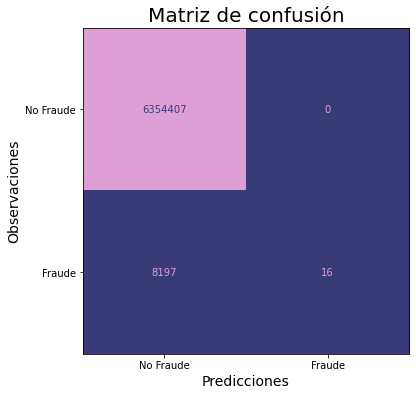

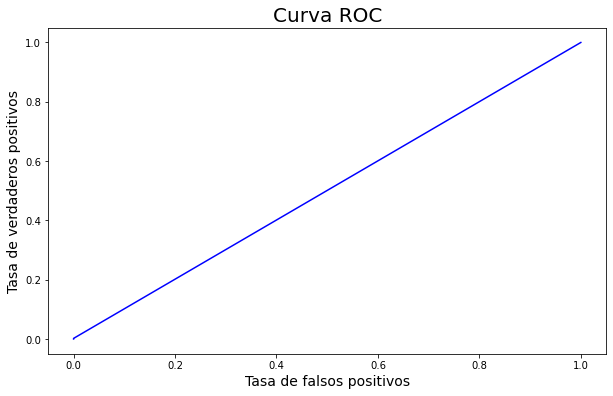

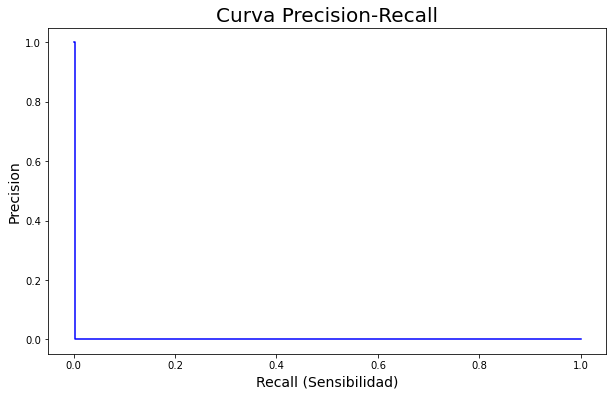

In [19]:
# Exportación a png.
from export import export_png

export_png(filename = 'baseline', y_pred = y_pred, y_test = y_true)

## 5. Ingeniería de predictores

In [20]:
# Se agregan 2 atributos adicionales para distinguir el día y hora de cada operación.
# 31 x 24 = 744 horas
from math import ceil
df['day'] = df['step'] / 24
df['day'] = df['day'].apply(lambda x: ceil(x))
df['hour'] = df['step'] / 31
df['hour'] = df['hour'].apply(lambda x: ceil(x))

In [21]:
# Filtro y orden de atributos.
df = df.loc[:, ['day', 'hour', 'type', 'amount', 'nameOrig', 'oldbalanceOrig',
              'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
              'isFraud', 'isFlaggedFraud']]

In [22]:
# Conversión de variable 'type' a dummies.
df = pd.get_dummies(df, columns = ['type'])

In [23]:
# Creación de serie uniendo las columnas 'nameOrig' y 'nameDest'.
ids = pd.concat(objs = (df['nameOrig'], df['nameDest']))
print('Longitud ids: %i' % len(ids))
print('Longitud registros: %i' % (len(df['nameOrig']) * 2))

Longitud ids: 12725240
Longitud registros: 12725240


In [24]:
# Obtención de IDs únicos.
ids_unique = ids.unique()
print('Longitud valores unicos ids: %i' % len(ids_unique))

Longitud valores unicos ids: 9073900


In [25]:
# Visualización de IDs únicos.
ids_unique

array(['C1231006815', 'C1666544295', 'C1305486145', ..., 'C1850423904',
       'C1881841831', 'C2080388513'], dtype=object)

In [26]:
# Creación de diccionario con índice y el valor obtenido del dataframe.
ids_dict = {j : i for i, j in enumerate(ids_unique)}

In [27]:
# Mapping de los IDs.
df['idOrig'] = df['nameOrig'].map(ids_dict)
df['idDest'] = df['nameDest'].map(ids_dict)

In [28]:
# Filtro y orden de atributos.
columns = ['day', 'hour', 'amount', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig',
           'idDest', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_IN', 'type_CASH_OUT',
           'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'isFraud', 'isFlaggedFraud']
df = df.loc[:, columns]

In [29]:
# Se renombran las columnas
df.columns = ['day', 'hour', 'amount', 'idOrig', 'oldbalanceOrig', 'newbalanceOrig',
              'idDest', 'oldbalanceDest', 'newbalanceDest', 'Cash_in',
              'Cash_out', 'Debit', 'Payment', 'Transfer',
              'isFraud', 'isFlaggedFraud']

## 6. Backup del dataset preprocesado

In [ ]:
# Creacion de archivos csv para almacenar variables.
df.to_csv(path_or_buf = 'df_preprocessed.csv', sep = ',', index = False)

In [ ]:
# Lectura de archivos de backup csv.
df_preprocessed = pd.read_csv('df_preprocessed.csv')